## 研究分解键级

In [ ]:
import sys
sys.path.append('d:/code/pywfn')
from pywfn.base import Mole
from pywfn.reader import LogReader
from pywfn.atomprop import direction
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from pywfn.bondprop import order
from pywfn.maths import CM2PM
from pywfn.maths.mol import projCM

动态链接库目录 d:\code\pywfn\pywfn\libs
当前系统:windows


In [113]:
def gtf(grid,l,m,n)->np.ndarray:
    x=grid[:,0]
    y=grid[:,1]
    z=grid[:,2]
    r2=x**2+y**2+z**2
    alp=2.0
    facs=[1,1,3]
    fac=facs[l]*facs[m]*facs[n]
    ang=l+m+n
    Nm=(2*alp/np.pi)**(3/4)*np.sqrt((4*alp)**ang/fac)
    val=x**l * y**m * z**n * np.exp(-alp*r2)*Nm
    return val


def decomOrbitals(T:np.ndarray,coefs:np.ndarray,keeps:list):
    match len(coefs):
        case 1:
            return decomOrbitalS(T,coefs,keeps)
        case 3:
            return decomOrbitalP(T,coefs,keeps)
        case 6:
            return decomOrbitalD(T,coefs,keeps)
        case _:
            return coefs

def decomOrbitalS(T:np.ndarray,coefs:np.ndarray,keeps:list[int]):
    if keeps:
        return coefs
    else:
        return np.array([0.])

# 分解P轨道
def decomOrbitalP(T:np.ndarray,rcoefs:np.ndarray,keeps:list[int])->np.ndarray:
    """分解P轨道

    Args:
        T (np.ndarray): 基坐标，每一行代表一个方向
        rcoefs (np.ndarray): 原始函数空间的基函数系数
        keeps (list[int]): 保留的角动量

    Returns:
        np.ndarray: 分解之后的轨道系数
    """
    npos=3
    cords=np.random.rand(npos,3) #随机生成3个点[n,3],[3,3]
    # cords=np.eye(3) #固定生成6个点
    wfn_1=np.zeros(shape=(npos,3)) #再这些点上的波函数数值
    wfn_1[:,0]=gtf(cords,1,0,0)
    wfn_1[:,1]=gtf(cords,0,1,0)
    wfn_1[:,2]=gtf(cords,0,0,1)

    wfn_2=np.zeros(shape=(npos,3))
    wfn_2[:,0]=gtf(cords@T,1,0,0)
    wfn_2[:,1]=gtf(cords@T,0,1,0)
    wfn_2[:,2]=gtf(cords@T,0,0,1)

    Mr=np.linalg.inv(wfn_2)@wfn_1
    Mi=np.linalg.inv(Mr)
    tcoefs=Mr@rcoefs # 根据函数空间基组1下的系数获取函数空间基组2下的系数
    for i in range(3):
        if i in keeps:continue
        tcoefs[i]=0.0
    fcoefs=Mi@tcoefs # 根据修改后的函数空间基组2下的系数得到函数空间基组1下的系数
    return fcoefs

# # 分解D轨道
# def decomOrbitalD(T:np.ndarray,rcoefs:np.ndarray,keeps:list[int]):
#     # return rcoefs
#     M=np.array([
#         [T[0,0]**2, T[0,0]*T[0,1], T[0,0]*T[0,2], T[0,1]**2, T[0,1]*T[0,2], T[0,2]**2],
#         [T[1,0]**2, T[1,0]*T[1,1], T[1,0]*T[1,2], T[1,1]**2, T[1,1]*T[1,2], T[1,2]**2],
#         [T[2,0]**2, T[2,0]*T[2,1], T[2,0]*T[2,2], T[2,1]**2, T[2,1]*T[2,2], T[2,2]**2],
#         [2*T[0,0]*T[1,0], (T[0,0]*T[1,1]+T[0,1]*T[1,0]), (T[0,0]*T[1,2]+T[0,2]*T[1,2]), 2*T[0,1]*T[1,1], (T[0,1]*T[1,2]+T[0,2]*T[1,1]), 2*T[0,2]*T[1,2]],
#         [2*T[0,0]*T[2,0], (T[0,0]*T[2,1]+T[0,1]*T[2,0]), (T[0,0]*T[2,2]+T[0,2]*T[2,0]), 2*T[0,1]*T[2,1], (T[0,1]*T[2,2]+T[0,2]*T[2,1]), 2*T[0,2]*T[2,2]],
#         [2*T[1,0]*T[2,0], (T[1,0]*T[2,1]+T[1,1]*T[2,0]), (T[1,0]*T[2,2]+T[1,2]*T[2,0]), 2*T[1,1]*T[2,1], (T[1,1]*T[2,2]+T[1,2]*T[2,1]), 2*T[1,2]*T[2,2]],
#     ])
#     npos=6
#     cords=np.random.rand(npos,3) #随机生成6个点
#     # cords=np.eye(6) #固定生成6个点
#     f11=lambda cords:gtf(cords,2,0,0)
#     f12=lambda cords:gtf(cords,0,2,0)
#     f13=lambda cords:gtf(cords,0,0,2)
#     f14=lambda cords:gtf(cords,1,1,0)
#     f15=lambda cords:gtf(cords,1,0,1)
#     f16=lambda cords:gtf(cords,0,1,1)
#     f1s=[f11,f12,f13,f14,f15,f16]
#     f21=lambda cords:gtf(cords@T,2,0,0)
#     f22=lambda cords:gtf(cords@T,0,2,0)
#     f23=lambda cords:gtf(cords@T,0,0,2)
#     f24=lambda cords:gtf(cords@T,1,1,0)
#     f25=lambda cords:gtf(cords@T,1,0,1)
#     f26=lambda cords:gtf(cords@T,0,1,1)
#     f2s=[f21,f22,f23,f24,f25,f26]
#     wfn_1=np.zeros(shape=(npos,6))
#     wfn_2=np.zeros(shape=(npos,6))
#     for i in range(6):
#         wfn_1[:,i]=f1s[i](cords)
#         wfn_2[:,i]=f2s[i](cords@T)

#     Mr=np.linalg.inv(wfn_2)@wfn_1
#     Mi=np.linalg.inv(Mr)
#     tcoefs=Mr@rcoefs
#     for i in range(6):
#         if i in keeps:continue
#         tcoefs[i]=0.0
    
#     fcoefs=Mi@tcoefs
#     print(f'{tcoefs}->{fcoefs}')
#     randP=np.random.rand(2,3)
#     v1=sum([c*f(randP) for c,f in zip(fcoefs,f1s)])
#     v2=sum([c*f(randP@T) for c,f in zip(tcoefs,f2s)])
#     print(f'{v1}->{v2}')
#     return fcoefs

def decomOrbitalD(T:np.ndarray,rcoefs:np.ndarray,keeps:list[int]):
    M=np.array([
        [T[0,0]**2, T[0,0]*T[0,1], T[0,0]*T[0,2], T[0,1]**2, T[0,1]*T[0,2], T[0,2]**2],
        [T[1,0]**2, T[1,0]*T[1,1], T[1,0]*T[1,2], T[1,1]**2, T[1,1]*T[1,2], T[1,2]**2],
        [T[2,0]**2, T[2,0]*T[2,1], T[2,0]*T[2,2], T[2,1]**2, T[2,1]*T[2,2], T[2,2]**2],
        [2*T[0,0]*T[1,0], (T[0,0]*T[1,1]+T[0,1]*T[1,0]), (T[0,0]*T[1,2]+T[0,2]*T[1,2]), 2*T[0,1]*T[1,1], (T[0,1]*T[1,2]+T[0,2]*T[1,1]), 2*T[0,2]*T[1,2]],
        [2*T[0,0]*T[2,0], (T[0,0]*T[2,1]+T[0,1]*T[2,0]), (T[0,0]*T[2,2]+T[0,2]*T[2,0]), 2*T[0,1]*T[2,1], (T[0,1]*T[2,2]+T[0,2]*T[2,1]), 2*T[0,2]*T[2,2]],
        [2*T[1,0]*T[2,0], (T[1,0]*T[2,1]+T[1,1]*T[2,0]), (T[1,0]*T[2,2]+T[1,2]*T[2,0]), 2*T[1,1]*T[2,1], (T[1,1]*T[2,2]+T[1,2]*T[2,1]), 2*T[1,2]*T[2,2]],
    ])
    # print('decomOrbitalD',np.linalg.norm(M,axis=0))
    # np.cross()
    Mr=np.linalg.inv(M)
    Mi=np.linalg.inv(Mr)
    tcoefs=Mr@rcoefs
    tcoefs*=np.array(keeps)
    fcoefs=Mi@tcoefs
    return fcoefs

# 分解D轨道
def decomOrbitalD2(T:np.ndarray,rcoefs:np.ndarray,keeps:list[int]):
    # return rcoefs
    npos=3
    cords=np.random.rand(npos,3) #随机生成6个点
    wfn_1=np.zeros(shape=(npos,3))
    wfn_1[:,0]=gtf(cords,1,1,0)
    wfn_1[:,1]=gtf(cords,1,0,1)
    wfn_1[:,2]=gtf(cords,0,1,1)

    wfn_2=np.zeros(shape=(npos,3))
    wfn_2[:,0]=gtf(cords@T,1,1,0)
    wfn_2[:,1]=gtf(cords@T,1,0,1)
    wfn_2[:,2]=gtf(cords@T,0,1,1)

    Mr=np.linalg.inv(wfn_2)@wfn_1
    Mi=np.linalg.inv(Mr)
    tcoefs=Mr@rcoefs
    for i in range(3):
        if i in keeps:continue
        tcoefs[i]=0.0
    print('>',tcoefs)
    fcoefs=Mi@tcoefs
    return fcoefs

In [35]:
rcoefs=np.random.rand(3) # 原始向量
x=np.random.rand(3)
x/=np.linalg.norm(x)
v=np.random.rand(3)
v/=np.linalg.norm(v)
y=np.cross(x,v)
y/=np.linalg.norm(y)
z=np.cross(x,y)
z/=np.linalg.norm(z)
T=np.array([x,y,z]).T # 变换矩阵

print(rcoefs)
print('-'*40)
ts=[]
for i in range(3):
    tcoefs=decomOrbitalD2(T,rcoefs,[i])
    ts.append(tcoefs)
    print('<',tcoefs)
print('-'*40)
print(np.sum(ts,axis=0))
print(np.sum(ts[1]*ts[2]))

[0.0072 0.0892 0.6843]
----------------------------------------
> [-225.0025    0.        0.    ]
< [-317.3673  187.2602  253.9957]
> [ 0.     -1.0607  0.    ]
< [ 11.4333   0.6135 -11.6611]
> [ 0.      0.     -3.6613]
< [-0.8194 -1.5808  2.9359]
----------------------------------------
[-306.7534  186.293   245.2705]
-44.574440089893194


In [114]:
rcoefs=np.random.rand(6) # 原始向量
x=np.random.rand(3)
x/=np.linalg.norm(x)
v=np.random.rand(3)
v/=np.linalg.norm(v)
y=np.cross(x,v)
y/=np.linalg.norm(y)
z=np.cross(x,y)
z/=np.linalg.norm(z)
T=np.array([x,y,z]).T # 变换矩阵


print(rcoefs)
print('-'*40)
keeps=[
    [1,1,1,0,0,0],
    [0,0,0,1,0,0],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1],
]
ts=[]
for keep in keeps:
    tcoefs=decomOrbitalD(T,rcoefs,keep)
    ts.append(tcoefs)
    print('<',tcoefs)
print('-'*40)
print(np.sum(ts,axis=0))

[0.6909 0.2084 0.7257 0.5621 0.6794 0.1344]
----------------------------------------
< [0.5413 0.0944 0.4932 0.3462 1.0461 0.4321]
< [ 0.0184  0.2348  0.1179  0.1313 -0.0931 -0.3327]
< [ 0.0623 -0.1537  0.0914  0.1797 -0.1939 -0.0201]
< [ 0.0689  0.0328  0.0231 -0.0951 -0.0799  0.0551]
----------------------------------------
[0.6909 0.2084 0.7257 0.5621 0.6794 0.1344]


np.float64(0.0016159225539921756)

In [ ]:
path=rf"D:\gfile\pywfn\C2_t.out"
mol=Mole(LogReader(path))
mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
mol.atom(3)._props['normal']=np.array([1,0,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,3)
sys2=dirCaler.coordSystem(3,1)

[0, 1, 2, 3, 4, 5, 6]

In [15]:
path=rf"D:\gfile\pywfn\C2.out"
mol=Mol(LogReader(path))
mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
mol.atom(3)._props['normal']=np.array([1,0,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,3)
sys2=dirCaler.coordSystem(3,1)
sys2=sys1
rcoefs=np.array([1.,2.,3.,4.,5.,6.])
decomOrbitals(sys1,rcoefs,[0])

array([ 0., -0.,  3.,  0., -0., -0.])

In [ ]:
path=rf"D:\gfile\pywfn\O2.out"
mol=Mole(LogReader(path))
mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
mol.atom(2)._props['normal']=np.array([1,0,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,2)
sys2=dirCaler.coordSystem(2,1)
atms=[1,2]

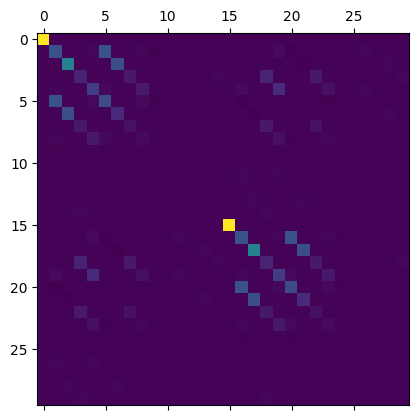

In [74]:
# 键级矩阵是对称的吗？
nobt=len(mol.O_obts)
CM=mol.CM[:,:nobt].copy()
PM=CM@CM.T
PS=PM@mol.SM
OM=PS*PS.T
plt.matshow(OM)

In [ ]:
path=rf"D:\gfile\HFV\键级分解\O2_nd.log"
mol=Mole(LogReader(path))
mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
mol.atom(2)._props['normal']=np.array([1,0,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,2)
sys2=dirCaler.coordSystem(2,1)
atms=[1,2]

In [ ]:
path=rf"D:\gfile\HFV\键级分解\O2_nd_nosymm.out"
mol=Mole(LogReader(path))
dirCaler=direction.Calculator(mol) # 方向计算器
# mol.atom(1)._props['normal']=dirCaler.maxWeave(1,7,'P[XYZ]')
# mol.atom(2)._props['normal']=dirCaler.maxWeave(2,7,'P[XYZ]')
mol.atom(1)._props['normal']=np.array([0.,0.,1.])
mol.atom(2)._props['normal']=np.array([0.,0.,1.])
sys1=dirCaler.coordSystem(1,2)
sys2=dirCaler.coordSystem(2,1)
atms=[1,2]

In [ ]:
path=rf"D:\gfile\pywfn\CH3-CH3.out"
mol=Mole(LogReader(path))
mol.atom(1)._props['normal']=np.array([0,1,0],dtype=float)
mol.atom(5)._props['normal']=np.array([0,1,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,5)
sys2=dirCaler.coordSystem(5,1)
atms=[1,5]
order.Calculator(mol).mayer()

array([[1.    , 2.    , 0.9563],
       [1.    , 3.    , 0.9562],
       [1.    , 4.    , 0.9562],
       [1.    , 5.    , 1.0267],
       [5.    , 6.    , 0.9562],
       [5.    , 7.    , 0.9562],
       [5.    , 8.    , 0.9563]])

In [ ]:
path=rf"D:\gfile\HFV\CH3-CH3_nd.out"
mol=Mole(LogReader(path))
mol.atom(1)._props['normal']=np.array([0,1,0],dtype=float)
mol.atom(5)._props['normal']=np.array([0,1,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,5)
sys2=dirCaler.coordSystem(5,1)
atms=[1,5]
order.Calculator(mol).mayer()

array([[1.    , 2.    , 0.9592],
       [1.    , 3.    , 0.9592],
       [1.    , 4.    , 0.9592],
       [1.    , 5.    , 0.9854],
       [5.    , 6.    , 0.9592],
       [5.    , 7.    , 0.9592],
       [5.    , 8.    , 0.9592]])

In [ ]:
path=rf"D:\gfile\HFV\CH2-CH2_nd.out"
mol=Mole(LogReader(path))
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,4)
sys2=dirCaler.coordSystem(4,1)
atms=[1,4]
order.Calculator(mol).mayer()

array([[1.    , 2.    , 0.9512],
       [1.    , 3.    , 0.9512],
       [1.    , 4.    , 2.0125],
       [4.    , 5.    , 0.9512],
       [4.    , 6.    , 0.9512]])

In [ ]:
path=rf"D:\gfile\pywfn\CH2=CH2_wfn.out"
mol=Mole(LogReader(path))
mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
mol.atom(4)._props['normal']=np.array([1,0,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,2)
sys2=dirCaler.coordSystem(2,1)
atms=[1,2]
order.Calculator(mol).mayer()

array([[1.    , 2.    , 0.9423],
       [1.    , 3.    , 0.9423],
       [1.    , 4.    , 2.0419],
       [4.    , 5.    , 0.9423],
       [4.    , 6.    , 0.9423]])

In [ ]:
path=rf"D:\gfile\pywfn\C6H6.log"
mol=Mole(LogReader(path))
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,2)
sys2=dirCaler.coordSystem(2,1)
atms=[1,2]
order.Calculator(mol).mayer()

array([[ 1.    ,  2.    ,  1.4533],
       [ 1.    ,  6.    ,  1.4533],
       [ 1.    ,  7.    ,  0.9299],
       [ 2.    ,  3.    ,  1.4533],
       [ 2.    ,  8.    ,  0.9299],
       [ 3.    ,  4.    ,  1.4533],
       [ 3.    ,  9.    ,  0.9299],
       [ 4.    ,  5.    ,  1.4533],
       [ 4.    , 10.    ,  0.9299],
       [ 5.    ,  6.    ,  1.4533],
       [ 5.    , 11.    ,  0.9299],
       [ 6.    , 12.    ,  0.9299]])

In [ ]:
path=rf"D:\gfile\HFV\键级分解\C6H6_nd.out"
mol=Mole(LogReader(path))
dirCaler=direction.Calculator(mol) # 方向计算器
atms=[3,4]
sys1=dirCaler.coordSystem(atms[0],atms[1])
sys2=dirCaler.coordSystem(atms[1],atms[0])


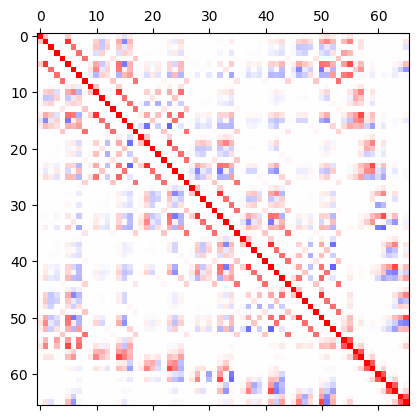

In [69]:
plt.matshow(mol.SM,vmin=-1,vmax=1,cmap='bwr')

In [ ]:
path=rf"D:\gfile\HFV\键级分解\complex.log"
mol=Mole(LogReader(path))
dirCaler=direction.Calculator(mol) # 方向计算器
atms=[12,14]
sys1=dirCaler.coordSystem(atms[0],atms[1])
sys2=dirCaler.coordSystem(atms[1],atms[0])

In [ ]:
Ts=[sys1,sys2]
sig_keeps={
    0:[0], #s
    1:[0], #px,py,pz
    2:[0,1,2]  #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引
piz_keeps={
    0:[], 
    1:[2], 
    2:[5]      # xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引
piy_keeps={
    0:[], 
    1:[1], 
    2:[4]  #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引
det_keeps={
    0:[], #s
    1:[], #px,py,pz
    2:[5] #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引

nmat=mol.CM.shape[0]
keepList=[sig_keeps,piz_keeps,piy_keeps,det_keeps]
orderCaler=order.Calculator(mol)
nobt=len(mol.O_obts)
CMs:list[np.ndarray]=[]
orders=[]
for k,keeps in enumerate(keepList):
    # if k!=1:continue
    CMt=np.zeros_like(mol.CM)
    for o in mol.O_obts: # 对每一个分子轨道进行修改
        coefDict=defaultdict(list) #系数字典
        for i in range(nmat): # 循环每一个系数
            iatm=mol.atoAtms[i]
            ishl=mol.atoShls[i]
            iang=mol.atoAngs[i]
            key=(iatm,ishl,iang)
            if iatm in atms:
                coefDict[key].append(mol.CM[i,o])
            else:
                # coefDict[key].append(0)
                coefDict[key].append(mol.CM[i,o])

        for key,val in coefDict.items():
            iatm,ishl,iang=key
            rcoefs=np.array(val)
            if iatm in atms:
                tcoefs=decomOrbitals(Ts[atms.index(iatm)],rcoefs,keeps[iang])
            else:
                # tcoefs=np.zeros_like(rcoefs)
                tcoefs=np.array(coefDict[key])
            # print(k,rcoefs,'->',tcoefs,keeps[iang])
            assert len(rcoefs)==len(tcoefs),"长度对不上"
            
            coefDict[key]=tcoefs.tolist()
        values=list(coefDict.values())
        CMt[:,o]=np.concatenate(values)
    file=open(f'CM{k}.txt','w')
    for i,line in enumerate(CMt[:,:nobt]):
        file.write(f'{mol.atoSyms[i]:<4}'+','.join([f'{e:>8.4f}' for e in line])+'\n')
    file.close()
    CMs.append(CMt)
    PMt=CM2PM(CMt,mol.O_obts,mol.oE) # 变换的密度矩阵
    bonds,results=orderCaler.mayer(PMt)
    # print(results)
    # values=results[:,-1]
    # values[values<0]=0
    # results[:,-1]=values#**0.5
    # orders.append(results[:,-1])
    for a1,a2,val in results:
        if a1 not in atms:continue
        if a2 not in atms:continue
        print(f'{a1:3>.0f}  {a2:3>.0f}{val:>8.4f}')
        orders.append(val)
    # print(results)
    print(f'{k:-^50}')
print(sum(orders))
file=open(f'CM.txt','w')
for i,line in enumerate(mol.CM[:,:nobt]):
    file.write(f'{mol.atoSyms[i]:<4}'+','.join([f'{e:>8.4f}' for e in line])+'\n')
file.close()
for a1,a2,val in orderCaler.mayer():
    if a1 not in atms:continue
    if a2 not in atms:continue
    print(val)
# print(orderCaler.mayer())

12  14-31.5375
------------------------0-------------------------
12  14 -3.9960
------------------------1-------------------------
12  14  6.1054
------------------------2-------------------------
12  14  0.0000
------------------------3-------------------------
-29.428003799452952
1.6295251568302245


In [57]:
np.linalg.norm(Ts[0],axis=0),np.linalg.norm(Ts[1],axis=0)

(array([1., 1., 1.]), array([1., 1., 1.]))

In [319]:
def get_PM(CM:np.ndarray)->np.ndarray:
    PM=CM@CM.T
    return PM
def get_OM(PM:np.ndarray,SM:np.ndarray)->np.ndarray:
    OM=(PM@SM)*(PM@SM).T
    return OM

C0,C1,C2,C3=[CMs[i][:,:nobt].copy() for i in range(4)]
P0,P1,P2,P3=[get_PM(C) for C in [C0,C1,C2,C3]]
O0,O1,O2,O3=[get_OM(O,mol.SM) for O in [P0,P1,P2,P3]]
CM=mol.CM[:,:nobt].copy()
PM=get_PM(CM)
OM=get_OM(PM,mol.SM)

In [322]:
for row in PM:
    print(','.join([(f'{e:>8.4f}' if abs(e)>1e-4 else '        ') for e in row]))

  1.0453, -0.1019,  0.0133,  0.0133,        , -0.1493,  0.0013,  0.0013,        , -0.0013,  0.0041,  0.0127,  0.0127,        ,  0.0366, -0.0069, -0.0069,        
 -0.1019,  0.3017, -0.0202, -0.0202,        ,  0.3165, -0.0065, -0.0065,        ,  0.0041, -0.0157, -0.0373, -0.0373,        , -0.0794,  0.0074,  0.0074,        
  0.0133, -0.0202,  0.3881, -0.1168,        , -0.0897,  0.2231, -0.1086,        , -0.0127,  0.0373, -0.1602, -0.0902,        , -0.0177, -0.0957, -0.0192,        
  0.0133, -0.0202, -0.1168,  0.3881,        , -0.0897, -0.1086,  0.2231,        , -0.0127,  0.0373, -0.0902, -0.1602,        , -0.0177, -0.0192, -0.0957,        
        ,        ,        ,        ,  0.2100,        ,        ,        ,  0.1288,        ,        ,        ,        ,  0.2100,        ,        ,        ,  0.1288
 -0.1493,  0.3165, -0.0897, -0.0897,        ,  0.3753, -0.0321, -0.0321,        ,  0.0366, -0.0794,  0.0177,  0.0177,        , -0.1211,  0.0335,  0.0335,        
  0.0013, -0.0065,  0.2231, 

In [320]:
for row in P0:
    print(','.join([(f'{e:>8.4f}' if abs(e)>1e-4 else '        ') for e in row]))

  1.0453, -0.1019,  0.0133,  0.0133,        , -0.1493,  0.0013,  0.0013,        , -0.0013,  0.0041,  0.0127,  0.0127,        ,  0.0366, -0.0069, -0.0069,        
 -0.1019,  0.3017, -0.0202, -0.0202,        ,  0.3165, -0.0065, -0.0065,        ,  0.0041, -0.0157, -0.0373, -0.0373,        , -0.0794,  0.0074,  0.0074,        
  0.0133, -0.0202,  0.1357,  0.1357,        , -0.0897,  0.0573,  0.0573,        , -0.0127,  0.0373, -0.1252, -0.1252,        , -0.0177, -0.0574, -0.0574,        
  0.0133, -0.0202,  0.1357,  0.1357,        , -0.0897,  0.0573,  0.0573,        , -0.0127,  0.0373, -0.1252, -0.1252,        , -0.0177, -0.0574, -0.0574,        
        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
 -0.1493,  0.3165, -0.0897, -0.0897,        ,  0.3753, -0.0321, -0.0321,        ,  0.0366, -0.0794,  0.0177,  0.0177,        , -0.1211,  0.0335,  0.0335,        
  0.0013, -0.0065,  0.0573, 

In [321]:
for row in P1:
    print(','.join([(f'{e:>8.4f}' if abs(e)>1e-4 else '        ') for e in row]))

        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,        ,        ,  0.2100,        ,        ,        ,  0.1288,        ,        ,        ,        ,  0.2100,        ,        ,        ,  0.1288
        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,        , 

In [316]:
for row in P2:
    print(','.join([(f'{e:>8.4f}' if abs(e)>1e-4 else '        ') for e in row]))

        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,  0.2525, -0.2525,        ,        ,  0.1659, -0.1659,        ,        ,        , -0.0350,  0.0350,        ,        , -0.0383,  0.0383,        
        ,        , -0.2525,  0.2525,        ,        , -0.1659,  0.1659,        ,        ,        ,  0.0350, -0.0350,        ,        ,  0.0383, -0.0383,        
        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        ,        
        ,        ,  0.1659, 

In [282]:
np.sum(OM)-np.sum(O0+O1+O2+O3)

np.float64(0.0)

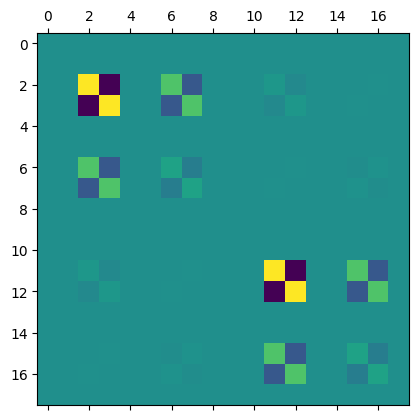

In [284]:
plt.matshow(OM-O0-O1-O2-O3)

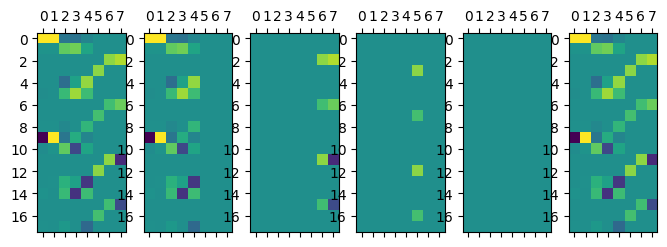

In [60]:
from matplotlib.axes._axes import Axes
fig,axs=plt.subplots(1,6,figsize=(8,5)) # type: ignore
axs:list[Axes]=axs
vmin=np.min(mol.CM[:,:nobt])
vmax=np.max(mol.CM[:,:nobt])
axs[0].matshow(mol.CM[:,:nobt],vmin=vmin,vmax=vmax)
axs[1].matshow(CMs[0][:,:nobt],vmin=vmin,vmax=vmax)
axs[2].matshow(CMs[1][:,:nobt],vmin=vmin,vmax=vmax)
axs[3].matshow(CMs[2][:,:nobt],vmin=vmin,vmax=vmax)
axs[4].matshow(CMs[3][:,:nobt],vmin=vmin,vmax=vmax)
axs[5].matshow((np.sum(CMs,axis=0))[:,:nobt],vmin=vmin,vmax=vmax)

In [61]:
(np.sum(CMs,axis=0))[:,:nobt]-mol.CM[:,:nobt]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -0., -0.,  0., -0., -0.,  0.,  0.],
       [ 0., -0., -0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0.,  0.,  0., -0., -0., -0.,  0.,  0.],
       [-0., -0.,  0., -0., -0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0., -0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0., -0.,  0.,  0., -0.,  0.]])

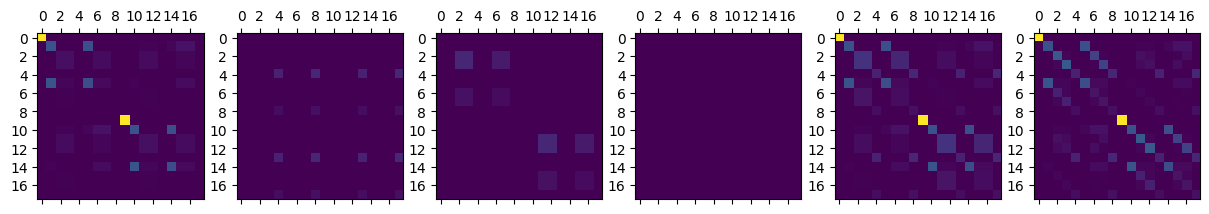

In [188]:
from matplotlib.axes._axes import Axes
def get_OM(CM,SM):
    OM=((CM@CM.T)@SM)**2
    return OM
OMs=[get_OM(CM[:,:nobt],mol.SM) for CM in CMs]
OMs.append(np.sum(OMs,axis=0))
OMs.append(get_OM(mol.CM[:,:nobt],mol.SM))
fig,axs=plt.subplots(1,6,figsize=(15,5)) # type: ignore
axs:list[Axes]=axs
vmin=np.min(OMs[4])
vmax=np.max(OMs[4])
for i in range(6):
    axs[i].matshow(OMs[i],vmin=vmin,vmax=vmax)

In [111]:
nmat=mol.CM.shape[0]
for i in range(nmat):
    symi=mol.obtSyms[i]
    atmi=mol.obtAtms[i]
    shli=mol.obtShls[i]
    for j in range(nmat):
        symj=mol.obtSyms[j]
        atmj=mol.obtAtms[j]
        shlj=mol.obtShls[j]
        print(f'{atmi} {shli}{symi:<4}{atmj} {shlj}{symj:<4}:{mol.SM[i,j]:>8.4f}')
    print('-'*60)

1 1S   1 1S   :  1.0000
1 1S   1 2S   :  0.2337
1 1S   1 2PX  :  0.0000
1 1S   1 2PY  :  0.0000
1 1S   1 2PZ  :  0.0000
1 1S   1 3S   :  0.1673
1 1S   1 3PX  :  0.0000
1 1S   1 3PY  :  0.0000
1 1S   1 3PZ  :  0.0000
1 1S   2 1S   :  0.0000
1 1S   2 2S   :  0.0028
1 1S   2 2PX  : -0.0053
1 1S   2 2PY  : -0.0053
1 1S   2 2PZ  :  0.0000
1 1S   2 3S   :  0.0382
1 1S   2 3PX  : -0.0646
1 1S   2 3PY  : -0.0646
1 1S   2 3PZ  :  0.0000
------------------------------------------------------------
1 2S   1 1S   :  0.2337
1 2S   1 2S   :  1.0000
1 2S   1 2PX  :  0.0000
1 2S   1 2PY  :  0.0000
1 2S   1 2PZ  :  0.0000
1 2S   1 3S   :  0.7636
1 2S   1 3PX  :  0.0000
1 2S   1 3PY  :  0.0000
1 2S   1 3PZ  :  0.0000
1 2S   2 1S   :  0.0028
1 2S   2 2S   :  0.0698
1 2S   2 2PX  : -0.0814
1 2S   2 2PY  : -0.0814
1 2S   2 2PZ  :  0.0000
1 2S   2 3S   :  0.2333
1 2S   2 3PX  : -0.3174
1 2S   2 3PY  : -0.3174
1 2S   2 3PZ  :  0.0000
------------------------------------------------------------
1 2PX  1 1S   

## 键级与系数
### 原子都在轴上的简单例子

In [88]:

import sympy as sp
def get_PM(rsyms):
    syms=[]
    for atm in range(2):
        for sym in rsyms:
            if sym==0:
                syms.append(0)
            else:
                syms.append(rf'\overrightarrow{{{atm+1}{sym}}} ')
    mat:list[list[sp.Symbol|int]]=[]
    for symi in syms:
        mat.append([])
        for symj in syms:
            if symi==0 or symj==0:
                mat[-1].append(0)
            else:
                mat[-1].append(sp.Symbol(f'{symi}·{symj}'))
    return sp.Matrix(mat)
P0=get_PM(['S','PZ'])
P1=get_PM(['S',0])
P2=get_PM([0,'PZ'])
smat:list[list[sp.Symbol]]=[]
rsyms=['1S','1PZ','2S','2PZ']
for i in range(4):
    smat.append([])
    si=rsyms[i]
    for j in range(4):
        sj=rsyms[j]
        smat[-1].append(sp.Symbol(f'S_{{{si},{sj}}}'))
SM=sp.Matrix(smat)
OM0=P0@SM
OM1=(P1+P2)@SM

In [86]:
P0

Matrix([
[ \overrightarrow{1S} ·\overrightarrow{1S} ,  \overrightarrow{1S} ·\overrightarrow{1PZ} ,  \overrightarrow{1S} ·\overrightarrow{2S} ,  \overrightarrow{1S} ·\overrightarrow{2PZ} ],
[\overrightarrow{1PZ} ·\overrightarrow{1S} , \overrightarrow{1PZ} ·\overrightarrow{1PZ} , \overrightarrow{1PZ} ·\overrightarrow{2S} , \overrightarrow{1PZ} ·\overrightarrow{2PZ} ],
[ \overrightarrow{2S} ·\overrightarrow{1S} ,  \overrightarrow{2S} ·\overrightarrow{1PZ} ,  \overrightarrow{2S} ·\overrightarrow{2S} ,  \overrightarrow{2S} ·\overrightarrow{2PZ} ],
[\overrightarrow{2PZ} ·\overrightarrow{1S} , \overrightarrow{2PZ} ·\overrightarrow{1PZ} , \overrightarrow{2PZ} ·\overrightarrow{2S} , \overrightarrow{2PZ} ·\overrightarrow{2PZ} ]])

In [87]:
P1+P2

Matrix([
[\overrightarrow{1S} ·\overrightarrow{1S} ,                                           0, \overrightarrow{1S} ·\overrightarrow{2S} ,                                           0],
[                                        0, \overrightarrow{1PZ} ·\overrightarrow{1PZ} ,                                         0, \overrightarrow{1PZ} ·\overrightarrow{2PZ} ],
[\overrightarrow{2S} ·\overrightarrow{1S} ,                                           0, \overrightarrow{2S} ·\overrightarrow{2S} ,                                           0],
[                                        0, \overrightarrow{2PZ} ·\overrightarrow{1PZ} ,                                         0, \overrightarrow{2PZ} ·\overrightarrow{2PZ} ]])

In [90]:
OM0[0,2]

S_{1PZ,2S}*\overrightarrow{1S} ·\overrightarrow{1PZ}  + S_{1S,2S}*\overrightarrow{1S} ·\overrightarrow{1S}  + S_{2PZ,2S}*\overrightarrow{1S} ·\overrightarrow{2PZ}  + S_{2S,2S}*\overrightarrow{1S} ·\overrightarrow{2S} 

In [91]:
OM1[0,2]

S_{1S,2S}*\overrightarrow{1S} ·\overrightarrow{1S}  + S_{2S,2S}*\overrightarrow{1S} ·\overrightarrow{2S} 

### 四个基函数

In [44]:
import sympy as sp
def get_PM(rsyms):
    syms=[]
    for atm in range(2):
        for sym in rsyms:
            if sym==0:
                syms.append(0)
            else:
                syms.append(rf'\overrightarrow{{{atm+1}{sym}}} ')
    mat:list[list[sp.Symbol|int]]=[]
    for symi in syms:
        mat.append([])
        for symj in syms:
            if symi==0 or symj==0:
                mat[-1].append(0)
            else:
                mat[-1].append(sp.Symbol(f'{symi}·{symj}'))
    return sp.Matrix(mat)
P0=get_PM(['S','PX','PY','PZ'])
P1=get_PM(['S','PX', 0, 0])
P2=get_PM([0, 0,'PY', 0])
P3=get_PM([0, 0, 0,'PZ'])
smat:list[list[sp.Symbol]]=[]
rsyms=['1S','1PX','1PY','1PZ','2S','2PX','2PY','2PZ']
for i in range(8):
    smat.append([])
    si=rsyms[i]
    for j in range(8):
        sj=rsyms[j]
        smat[-1].append(sp.Symbol(f'S_{{{si},{sj}}}'))
SM=sp.Matrix(smat)
SM

Matrix([
[ S_{1S,1S},  S_{1S,1PX},  S_{1S,1PY},  S_{1S,1PZ},  S_{1S,2S},  S_{1S,2PX},  S_{1S,2PY},  S_{1S,2PZ}],
[S_{1PX,1S}, S_{1PX,1PX}, S_{1PX,1PY}, S_{1PX,1PZ}, S_{1PX,2S}, S_{1PX,2PX}, S_{1PX,2PY}, S_{1PX,2PZ}],
[S_{1PY,1S}, S_{1PY,1PX}, S_{1PY,1PY}, S_{1PY,1PZ}, S_{1PY,2S}, S_{1PY,2PX}, S_{1PY,2PY}, S_{1PY,2PZ}],
[S_{1PZ,1S}, S_{1PZ,1PX}, S_{1PZ,1PY}, S_{1PZ,1PZ}, S_{1PZ,2S}, S_{1PZ,2PX}, S_{1PZ,2PY}, S_{1PZ,2PZ}],
[ S_{2S,1S},  S_{2S,1PX},  S_{2S,1PY},  S_{2S,1PZ},  S_{2S,2S},  S_{2S,2PX},  S_{2S,2PY},  S_{2S,2PZ}],
[S_{2PX,1S}, S_{2PX,1PX}, S_{2PX,1PY}, S_{2PX,1PZ}, S_{2PX,2S}, S_{2PX,2PX}, S_{2PX,2PY}, S_{2PX,2PZ}],
[S_{2PY,1S}, S_{2PY,1PX}, S_{2PY,1PY}, S_{2PY,1PZ}, S_{2PY,2S}, S_{2PY,2PX}, S_{2PY,2PY}, S_{2PY,2PZ}],
[S_{2PZ,1S}, S_{2PZ,1PX}, S_{2PZ,1PY}, S_{2PZ,1PZ}, S_{2PZ,2S}, S_{2PZ,2PX}, S_{2PZ,2PY}, S_{2PZ,2PZ}]])

In [79]:
OM0=P0@SM
#OM0=OM0*OM0.T

In [81]:
OM1=(P1+P2+P3)@SM
#OM1=OM1*OM1.T

In [82]:
OM0[0,4]

S_{1PX,2S}*\overrightarrow{1S} ·\overrightarrow{1PX}  + S_{1PY,2S}*\overrightarrow{1S} ·\overrightarrow{1PY}  + S_{1PZ,2S}*\overrightarrow{1S} ·\overrightarrow{1PZ}  + S_{1S,2S}*\overrightarrow{1S} ·\overrightarrow{1S}  + S_{2PX,2S}*\overrightarrow{1S} ·\overrightarrow{2PX}  + S_{2PY,2S}*\overrightarrow{1S} ·\overrightarrow{2PY}  + S_{2PZ,2S}*\overrightarrow{1S} ·\overrightarrow{2PZ}  + S_{2S,2S}*\overrightarrow{1S} ·\overrightarrow{2S} 

In [83]:
OM1[0,4]

S_{1PX,2S}*(\overrightarrow{1S^0} ·\overrightarrow{1PX^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PX^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PX^2} ) + S_{1PY,2S}*(\overrightarrow{1S^0} ·\overrightarrow{1PY^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PY^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PY^2} ) + S_{1PZ,2S}*(\overrightarrow{1S^0} ·\overrightarrow{1PZ^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PZ^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PZ^2} ) + S_{1S,2S}*(\overrightarrow{1S^0} ·\overrightarrow{1S^0}  + \overrightarrow{1S^1} ·\overrightarrow{1S^1}  + \overrightarrow{1S^2} ·\overrightarrow{1S^2} ) + S_{2PX,2S}*(\overrightarrow{1S^0} ·\overrightarrow{2PX^0}  + \overrightarrow{1S^1} ·\overrightarrow{2PX^1}  + \overrightarrow{1S^2} ·\overrightarrow{2PX^2} ) + S_{2PY,2S}*(\overrightarrow{1S^0} ·\overrightarrow{2PY^0}  + \overrightarrow{1S^1} ·\overrightarrow{2PY^1}  + \overrightarrow{1S^2} ·\overrightarrow{2PY^2} ) + S_{2PZ,2S}*(\overrightarrow{1S^0} ·\overrigh

## 原子不在轴上

In [55]:
import sympy as sp
def get_PM(rsyms):
    syms=[]
    for atm in range(2):
        for sym in rsyms:
            if sym==0:
                syms.append(0)
            else:
                syms.append(rf'\overrightarrow{{{atm+1}{sym}}} ')
    mat:list[list[sp.Symbol|int]]=[]
    for symi in syms:
        mat.append([])
        for symj in syms:
            if symi==0 or symj==0:
                mat[-1].append(0)
            else:
                mat[-1].append(sp.Symbol(f'{symi}·{symj}'))
    return sp.Matrix(mat)
P0=get_PM(['S','PX','PY','PZ'])
P1=get_PM(['S^0','PX^0','PY^0','PZ^0'])
P2=get_PM(['S^1','PX^1','PY^1','PZ^1'])
P3=get_PM(['S^2','PX^2','PY^2','PZ^2'])
smat:list[list[sp.Symbol]]=[]
rsyms=['1S','1PX','1PY','1PZ','2S','2PX','2PY','2PZ']
for i in range(8):
    smat.append([])
    si=rsyms[i]
    for j in range(8):
        sj=rsyms[j]
        smat[-1].append(sp.Symbol(f'S_{{{si},{sj}}}'))
SM=sp.Matrix(smat)
SM

Matrix([
[ S_{1S,1S},  S_{1S,1PX},  S_{1S,1PY},  S_{1S,1PZ},  S_{1S,2S},  S_{1S,2PX},  S_{1S,2PY},  S_{1S,2PZ}],
[S_{1PX,1S}, S_{1PX,1PX}, S_{1PX,1PY}, S_{1PX,1PZ}, S_{1PX,2S}, S_{1PX,2PX}, S_{1PX,2PY}, S_{1PX,2PZ}],
[S_{1PY,1S}, S_{1PY,1PX}, S_{1PY,1PY}, S_{1PY,1PZ}, S_{1PY,2S}, S_{1PY,2PX}, S_{1PY,2PY}, S_{1PY,2PZ}],
[S_{1PZ,1S}, S_{1PZ,1PX}, S_{1PZ,1PY}, S_{1PZ,1PZ}, S_{1PZ,2S}, S_{1PZ,2PX}, S_{1PZ,2PY}, S_{1PZ,2PZ}],
[ S_{2S,1S},  S_{2S,1PX},  S_{2S,1PY},  S_{2S,1PZ},  S_{2S,2S},  S_{2S,2PX},  S_{2S,2PY},  S_{2S,2PZ}],
[S_{2PX,1S}, S_{2PX,1PX}, S_{2PX,1PY}, S_{2PX,1PZ}, S_{2PX,2S}, S_{2PX,2PX}, S_{2PX,2PY}, S_{2PX,2PZ}],
[S_{2PY,1S}, S_{2PY,1PX}, S_{2PY,1PY}, S_{2PY,1PZ}, S_{2PY,2S}, S_{2PY,2PX}, S_{2PY,2PY}, S_{2PY,2PZ}],
[S_{2PZ,1S}, S_{2PZ,1PX}, S_{2PZ,1PY}, S_{2PZ,1PZ}, S_{2PZ,2S}, S_{2PZ,2PX}, S_{2PZ,2PY}, S_{2PZ,2PZ}]])

In [59]:
OM0=P0@SM
OM1=(P1+P2+P3)@SM

In [63]:
P0

Matrix([
[ \overrightarrow{1S} ·\overrightarrow{1S} ,  \overrightarrow{1S} ·\overrightarrow{1PX} ,  \overrightarrow{1S} ·\overrightarrow{1PY} ,  \overrightarrow{1S} ·\overrightarrow{1PZ} ,  \overrightarrow{1S} ·\overrightarrow{2S} ,  \overrightarrow{1S} ·\overrightarrow{2PX} ,  \overrightarrow{1S} ·\overrightarrow{2PY} ,  \overrightarrow{1S} ·\overrightarrow{2PZ} ],
[\overrightarrow{1PX} ·\overrightarrow{1S} , \overrightarrow{1PX} ·\overrightarrow{1PX} , \overrightarrow{1PX} ·\overrightarrow{1PY} , \overrightarrow{1PX} ·\overrightarrow{1PZ} , \overrightarrow{1PX} ·\overrightarrow{2S} , \overrightarrow{1PX} ·\overrightarrow{2PX} , \overrightarrow{1PX} ·\overrightarrow{2PY} , \overrightarrow{1PX} ·\overrightarrow{2PZ} ],
[\overrightarrow{1PY} ·\overrightarrow{1S} , \overrightarrow{1PY} ·\overrightarrow{1PX} , \overrightarrow{1PY} ·\overrightarrow{1PY} , \overrightarrow{1PY} ·\overrightarrow{1PZ} , \overrightarrow{1PY} ·\overrightarrow{2S} , \overrightarrow{1PY} ·\overrightarrow{2PX} , \o

In [62]:
P1+P2+P3

Matrix([
[   \overrightarrow{1S^0} ·\overrightarrow{1S^0}  + \overrightarrow{1S^1} ·\overrightarrow{1S^1}  + \overrightarrow{1S^2} ·\overrightarrow{1S^2} ,    \overrightarrow{1S^0} ·\overrightarrow{1PX^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PX^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PX^2} ,    \overrightarrow{1S^0} ·\overrightarrow{1PY^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PY^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PY^2} ,    \overrightarrow{1S^0} ·\overrightarrow{1PZ^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PZ^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PZ^2} ,    \overrightarrow{1S^0} ·\overrightarrow{2S^0}  + \overrightarrow{1S^1} ·\overrightarrow{2S^1}  + \overrightarrow{1S^2} ·\overrightarrow{2S^2} ,    \overrightarrow{1S^0} ·\overrightarrow{2PX^0}  + \overrightarrow{1S^1} ·\overrightarrow{2PX^1}  + \overrightarrow{1S^2} ·\overrightarrow{2PX^2} ,    \overrightarrow{1S^0} ·\overrightarrow{2PY^0}  + \overrightarrow{1S^1} ·\overrightarrow{2PY^1}  + \

In [60]:
OM0[0,4]

S_{1PX,2S}*\overrightarrow{1S} ·\overrightarrow{1PX}  + S_{1PY,2S}*\overrightarrow{1S} ·\overrightarrow{1PY}  + S_{1PZ,2S}*\overrightarrow{1S} ·\overrightarrow{1PZ}  + S_{1S,2S}*\overrightarrow{1S} ·\overrightarrow{1S}  + S_{2PX,2S}*\overrightarrow{1S} ·\overrightarrow{2PX}  + S_{2PY,2S}*\overrightarrow{1S} ·\overrightarrow{2PY}  + S_{2PZ,2S}*\overrightarrow{1S} ·\overrightarrow{2PZ}  + S_{2S,2S}*\overrightarrow{1S} ·\overrightarrow{2S} 

In [61]:
OM1[0,4]

S_{1PX,2S}*(\overrightarrow{1S^0} ·\overrightarrow{1PX^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PX^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PX^2} ) + S_{1PY,2S}*(\overrightarrow{1S^0} ·\overrightarrow{1PY^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PY^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PY^2} ) + S_{1PZ,2S}*(\overrightarrow{1S^0} ·\overrightarrow{1PZ^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PZ^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PZ^2} ) + S_{1S,2S}*(\overrightarrow{1S^0} ·\overrightarrow{1S^0}  + \overrightarrow{1S^1} ·\overrightarrow{1S^1}  + \overrightarrow{1S^2} ·\overrightarrow{1S^2} ) + S_{2PX,2S}*(\overrightarrow{1S^0} ·\overrightarrow{2PX^0}  + \overrightarrow{1S^1} ·\overrightarrow{2PX^1}  + \overrightarrow{1S^2} ·\overrightarrow{2PX^2} ) + S_{2PY,2S}*(\overrightarrow{1S^0} ·\overrightarrow{2PY^0}  + \overrightarrow{1S^1} ·\overrightarrow{2PY^1}  + \overrightarrow{1S^2} ·\overrightarrow{2PY^2} ) + S_{2PZ,2S}*(\overrightarrow{1S^0} ·\overrigh

In [64]:
OM0[0,5]

S_{1PX,2PX}*\overrightarrow{1S} ·\overrightarrow{1PX}  + S_{1PY,2PX}*\overrightarrow{1S} ·\overrightarrow{1PY}  + S_{1PZ,2PX}*\overrightarrow{1S} ·\overrightarrow{1PZ}  + S_{1S,2PX}*\overrightarrow{1S} ·\overrightarrow{1S}  + S_{2PX,2PX}*\overrightarrow{1S} ·\overrightarrow{2PX}  + S_{2PY,2PX}*\overrightarrow{1S} ·\overrightarrow{2PY}  + S_{2PZ,2PX}*\overrightarrow{1S} ·\overrightarrow{2PZ}  + S_{2S,2PX}*\overrightarrow{1S} ·\overrightarrow{2S} 

In [65]:
OM1[0,5]

S_{1PX,2PX}*(\overrightarrow{1S^0} ·\overrightarrow{1PX^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PX^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PX^2} ) + S_{1PY,2PX}*(\overrightarrow{1S^0} ·\overrightarrow{1PY^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PY^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PY^2} ) + S_{1PZ,2PX}*(\overrightarrow{1S^0} ·\overrightarrow{1PZ^0}  + \overrightarrow{1S^1} ·\overrightarrow{1PZ^1}  + \overrightarrow{1S^2} ·\overrightarrow{1PZ^2} ) + S_{1S,2PX}*(\overrightarrow{1S^0} ·\overrightarrow{1S^0}  + \overrightarrow{1S^1} ·\overrightarrow{1S^1}  + \overrightarrow{1S^2} ·\overrightarrow{1S^2} ) + S_{2PX,2PX}*(\overrightarrow{1S^0} ·\overrightarrow{2PX^0}  + \overrightarrow{1S^1} ·\overrightarrow{2PX^1}  + \overrightarrow{1S^2} ·\overrightarrow{2PX^2} ) + S_{2PY,2PX}*(\overrightarrow{1S^0} ·\overrightarrow{2PY^0}  + \overrightarrow{1S^1} ·\overrightarrow{2PY^1}  + \overrightarrow{1S^2} ·\overrightarrow{2PY^2} ) + S_{2PZ,2PX}*(\overrightarrow{1S^0} ·\o

In [66]:
OM1[5,0]

S_{1PX,1S}*(\overrightarrow{2PX^0} ·\overrightarrow{1PX^0}  + \overrightarrow{2PX^1} ·\overrightarrow{1PX^1}  + \overrightarrow{2PX^2} ·\overrightarrow{1PX^2} ) + S_{1PY,1S}*(\overrightarrow{2PX^0} ·\overrightarrow{1PY^0}  + \overrightarrow{2PX^1} ·\overrightarrow{1PY^1}  + \overrightarrow{2PX^2} ·\overrightarrow{1PY^2} ) + S_{1PZ,1S}*(\overrightarrow{2PX^0} ·\overrightarrow{1PZ^0}  + \overrightarrow{2PX^1} ·\overrightarrow{1PZ^1}  + \overrightarrow{2PX^2} ·\overrightarrow{1PZ^2} ) + S_{1S,1S}*(\overrightarrow{2PX^0} ·\overrightarrow{1S^0}  + \overrightarrow{2PX^1} ·\overrightarrow{1S^1}  + \overrightarrow{2PX^2} ·\overrightarrow{1S^2} ) + S_{2PX,1S}*(\overrightarrow{2PX^0} ·\overrightarrow{2PX^0}  + \overrightarrow{2PX^1} ·\overrightarrow{2PX^1}  + \overrightarrow{2PX^2} ·\overrightarrow{2PX^2} ) + S_{2PY,1S}*(\overrightarrow{2PX^0} ·\overrightarrow{2PY^0}  + \overrightarrow{2PX^1} ·\overrightarrow{2PY^1}  + \overrightarrow{2PX^2} ·\overrightarrow{2PY^2} ) + S_{2PZ,1S}*(\overrightarro

In [186]:
S=np.random.rand(10,10)
S=S@S.T
P1=np.random.rand(10,10)
P1=P1@P1.T
P2=np.random.rand(10,10)
P2=P2@P2.T
P=P1+P2
(P@S)*(P@S).T-(P1@S)*(P1@S).T-(P2@S)*(P2@S).T

array([[ 7846.9911,  6264.3527,  8137.9936,  4737.8589,  7169.0491,
         6376.039 ,  7665.9575,  9452.6181,  8021.6333,  3979.836 ],
       [ 6264.3527,  5002.1637,  6560.3303,  3785.2064,  6143.0294,
         5251.7883,  6021.9304,  7441.9144,  6497.0768,  3386.8129],
       [ 8137.9936,  6560.3303,  8536.4758,  4924.7331,  7651.3607,
         6669.7132,  7972.6823,  9855.9494,  8401.8864,  4216.0045],
       [ 4737.8589,  3785.2064,  4924.7331,  2942.597 ,  4458.0851,
         3954.8876,  4657.2812,  5676.8669,  4972.8654,  2483.0865],
       [ 7169.0491,  6143.0294,  7651.3607,  4458.0851,  6784.2363,
         5848.8409,  7338.2878,  9177.2709,  7780.2802,  3713.1634],
       [ 6376.039 ,  5251.7883,  6669.7132,  3954.8876,  5848.8409,
         5286.713 ,  6322.2991,  7849.1335,  6765.4375,  3291.8536],
       [ 7665.9575,  6021.9304,  7972.6823,  4657.2812,  7338.2878,
         6322.2991,  7607.9428,  9141.3636,  7927.79  ,  4055.0675],
       [ 9452.6181,  7441.9144,  9855.949

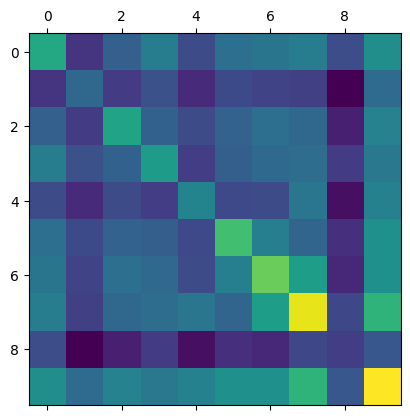

In [175]:
plt.matshow(P)

## 使用sympy推导

In [170]:
import sympy as sp
syms0:list[list[sp.Symbol]]=[]
syms1:list[list[sp.Symbol]]=[]
syms2:list[list[sp.Symbol]]=[]
for i in range(3):
    syms0.append([])
    syms1.append([])
    syms2.append([])
    for j in range(2):
        syms0[-1].append(sp.Symbol(f'C_{{{i+1}{j+1}}}'))
        syms1[-1].append(sp.Symbol(f'C_{{{i+1}{j+1}}}^1'))
        syms2[-1].append(sp.Symbol(f'C_{{{i+1}{j+1}}}^2'))
C=sp.Matrix(syms0)
C1=sp.Matrix(syms1)
C2=sp.Matrix(syms2)
C

Matrix([
[C_{11}, C_{12}],
[C_{21}, C_{22}],
[C_{31}, C_{32}]])

In [175]:
import sympy as sp
syms:list[list[sp.Symbol]]=[]
for i in range(3):
    syms.append([])
    for j in range(3):
        syms[-1].append(sp.Symbol(f'S_{{{i+1}{j+1}}}'))
S=sp.Matrix(syms)
S

Matrix([
[S_{11}, S_{12}, S_{13}],
[S_{21}, S_{22}, S_{23}],
[S_{31}, S_{32}, S_{33}]])

In [176]:
def get_OM(C,S):
    P=C@C.T
    O=(P@S)*(P@S).T
    return O

In [179]:
OM0=get_OM(C,S)
OM0

Matrix([
[                                                                                                                                                                                                                                                                                                                                                (S_{11}*(C_{11}**2 + C_{12}**2) + S_{21}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{31}*(C_{11}*C_{31} + C_{12}*C_{32}))**2 + (S_{12}*(C_{11}**2 + C_{12}**2) + S_{22}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{32}*(C_{11}*C_{31} + C_{12}*C_{32}))**2 + (S_{13}*(C_{11}**2 + C_{12}**2) + S_{23}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{33}*(C_{11}*C_{31} + C_{12}*C_{32}))**2, (S_{11}*(C_{11}**2 + C_{12}**2) + S_{21}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{31}*(C_{11}*C_{31} + C_{12}*C_{32}))*(S_{11}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{21}*(C_{21}**2 + C_{22}**2) + S_{31}*(C_{21}*C_{31} + C_{22}*C_{32})) + (S_{12}*(C_{11}**2 + C_{12}**2) + S_{22}*(C_{11}*C_{21} + C_{12

In [180]:
OM1=get_OM(C1,S)+get_OM(C2,S)
OM1

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        (S_{11}*(C_{11}^1**2 + C_{12}^1**2) + S_{21}*(C_{11}^1*C_{21}^1 + C_{12}^1*C_{22}^1) + S_{31}*(C_{11}^1*C_{31}^1 + C_{12}^1*C_{32}^1))**2 + (S_{11}*(C_{11}^2**2 + C_{12}^2**2) + S_{21}*(C_{11}^2*C_{

In [181]:
OM0[0,1]

(S_{11}*(C_{11}**2 + C_{12}**2) + S_{21}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{31}*(C_{11}*C_{31} + C_{12}*C_{32}))*(S_{11}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{21}*(C_{21}**2 + C_{22}**2) + S_{31}*(C_{21}*C_{31} + C_{22}*C_{32})) + (S_{12}*(C_{11}**2 + C_{12}**2) + S_{22}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{32}*(C_{11}*C_{31} + C_{12}*C_{32}))*(S_{12}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{22}*(C_{21}**2 + C_{22}**2) + S_{32}*(C_{21}*C_{31} + C_{22}*C_{32})) + (S_{13}*(C_{11}**2 + C_{12}**2) + S_{23}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{33}*(C_{11}*C_{31} + C_{12}*C_{32}))*(S_{13}*(C_{11}*C_{21} + C_{12}*C_{22}) + S_{23}*(C_{21}**2 + C_{22}**2) + S_{33}*(C_{21}*C_{31} + C_{22}*C_{32}))

In [ ]:
OM1[0,1]

(S_{11}*(C_{11}^1**2 + C_{12}^1**2) + S_{21}*(C_{11}^1*C_{21}^1 + C_{12}^1*C_{22}^1) + S_{31}*(C_{11}^1*C_{31}^1 + C_{12}^1*C_{32}^1))*(S_{11}*(C_{11}^1*C_{21}^1 + C_{12}^1*C_{22}^1) + S_{21}*(C_{21}^1**2 + C_{22}^1**2) + S_{31}*(C_{21}^1*C_{31}^1 + C_{22}^1*C_{32}^1)) + (S_{11}*(C_{11}^2**2 + C_{12}^2**2) + S_{21}*(C_{11}^2*C_{21}^2 + C_{12}^2*C_{22}^2) + S_{31}*(C_{11}^2*C_{31}^2 + C_{12}^2*C_{32}^2))*(S_{11}*(C_{11}^2*C_{21}^2 + C_{12}^2*C_{22}^2) + S_{21}*(C_{21}^2**2 + C_{22}^2**2) + S_{31}*(C_{21}^2*C_{31}^2 + C_{22}^2*C_{32}^2)) + (S_{12}*(C_{11}^1**2 + C_{12}^1**2) + S_{22}*(C_{11}^1*C_{21}^1 + C_{12}^1*C_{22}^1) + S_{32}*(C_{11}^1*C_{31}^1 + C_{12}^1*C_{32}^1))*(S_{12}*(C_{11}^1*C_{21}^1 + C_{12}^1*C_{22}^1) + S_{22}*(C_{21}^1**2 + C_{22}^1**2) + S_{32}*(C_{21}^1*C_{31}^1 + C_{22}^1*C_{32}^1)) + (S_{12}*(C_{11}^2**2 + C_{12}^2**2) + S_{22}*(C_{11}^2*C_{21}^2 + C_{12}^2*C_{22}^2) + S_{32}*(C_{11}^2*C_{31}^2 + C_{12}^2*C_{32}^2))*(S_{12}*(C_{11}^2*C_{21}^2 + C_{12}^2*C_{22}^2) +

In [184]:
syms0:list[list[sp.Symbol]]=[]
syms1:list[list[sp.Symbol]]=[]
syms2:list[list[sp.Symbol]]=[]
for i in range(3):
    syms0.append([])
    syms1.append([])
    syms2.append([])
    for j in range(3):
        syms0[-1].append(sp.Symbol(f'P_{{{i+1}{j+1}}}'))
        syms1[-1].append(sp.Symbol(f'P_{{{i+1}{j+1}}}^1'))
        syms2[-1].append(sp.Symbol(f'P_{{{i+1}{j+1}}}^2'))
P=sp.Matrix(syms0)
P1=sp.Matrix(syms1)
P2=sp.Matrix(syms2)
P

Matrix([
[P_{11}, P_{12}, P_{13}],
[P_{21}, P_{22}, P_{23}],
[P_{31}, P_{32}, P_{33}]])

In [185]:
def get_OM2(P,S):
    O=(P@S)*(P@S).T
    return O

In [191]:
OM0=get_OM2(P,S)
OM0

Matrix([
[                                                                                                                                       (P_{11}*S_{11} + P_{12}*S_{21} + P_{13}*S_{31})**2 + (P_{11}*S_{12} + P_{12}*S_{22} + P_{13}*S_{32})**2 + (P_{11}*S_{13} + P_{12}*S_{23} + P_{13}*S_{33})**2, (P_{11}*S_{11} + P_{12}*S_{21} + P_{13}*S_{31})*(P_{21}*S_{11} + P_{22}*S_{21} + P_{23}*S_{31}) + (P_{11}*S_{12} + P_{12}*S_{22} + P_{13}*S_{32})*(P_{21}*S_{12} + P_{22}*S_{22} + P_{23}*S_{32}) + (P_{11}*S_{13} + P_{12}*S_{23} + P_{13}*S_{33})*(P_{21}*S_{13} + P_{22}*S_{23} + P_{23}*S_{33}), (P_{11}*S_{11} + P_{12}*S_{21} + P_{13}*S_{31})*(P_{31}*S_{11} + P_{32}*S_{21} + P_{33}*S_{31}) + (P_{11}*S_{12} + P_{12}*S_{22} + P_{13}*S_{32})*(P_{31}*S_{12} + P_{32}*S_{22} + P_{33}*S_{32}) + (P_{11}*S_{13} + P_{12}*S_{23} + P_{13}*S_{33})*(P_{31}*S_{13} + P_{32}*S_{23} + P_{33}*S_{33})],
[(P_{11}*S_{11} + P_{12}*S_{21} + P_{13}*S_{31})*(P_{21}*S_{11} + P_{22}*S_{21} + P_{23}*S_{31}) + (P_{11}*S_{

In [192]:
OM1=get_OM2(P1,S)+get_OM2(P2,S)
OM1

Matrix([
[                                                                                                                                                                                                                                                                                                                  (P_{11}^1*S_{11} + P_{12}^1*S_{21} + P_{13}^1*S_{31})**2 + (P_{11}^1*S_{12} + P_{12}^1*S_{22} + P_{13}^1*S_{32})**2 + (P_{11}^1*S_{13} + P_{12}^1*S_{23} + P_{13}^1*S_{33})**2 + (P_{11}^2*S_{11} + P_{12}^2*S_{21} + P_{13}^2*S_{31})**2 + (P_{11}^2*S_{12} + P_{12}^2*S_{22} + P_{13}^2*S_{32})**2 + (P_{11}^2*S_{13} + P_{12}^2*S_{23} + P_{13}^2*S_{33})**2, (P_{11}^1*S_{11} + P_{12}^1*S_{21} + P_{13}^1*S_{31})*(P_{21}^1*S_{11} + P_{22}^1*S_{21} + P_{23}^1*S_{31}) + (P_{11}^1*S_{12} + P_{12}^1*S_{22} + P_{13}^1*S_{32})*(P_{21}^1*S_{12} + P_{22}^1*S_{22} + P_{23}^1*S_{32}) + (P_{11}^1*S_{13} + P_{12}^1*S_{23} + P_{13}^1*S_{33})*(P_{21}^1*S_{13} + P_{22}^1*S_{23} + P_{23}^1*S_{33}) + (

In [199]:
OM0[0,1]

(P_{11}*S_{11} + P_{12}*S_{21} + P_{13}*S_{31})*(P_{21}*S_{11} + P_{22}*S_{21} + P_{23}*S_{31}) + (P_{11}*S_{12} + P_{12}*S_{22} + P_{13}*S_{32})*(P_{21}*S_{12} + P_{22}*S_{22} + P_{23}*S_{32}) + (P_{11}*S_{13} + P_{12}*S_{23} + P_{13}*S_{33})*(P_{21}*S_{13} + P_{22}*S_{23} + P_{23}*S_{33})

In [200]:
OM1[0,1]

(P_{11}^1*S_{11} + P_{12}^1*S_{21} + P_{13}^1*S_{31})*(P_{21}^1*S_{11} + P_{22}^1*S_{21} + P_{23}^1*S_{31}) + (P_{11}^1*S_{12} + P_{12}^1*S_{22} + P_{13}^1*S_{32})*(P_{21}^1*S_{12} + P_{22}^1*S_{22} + P_{23}^1*S_{32}) + (P_{11}^1*S_{13} + P_{12}^1*S_{23} + P_{13}^1*S_{33})*(P_{21}^1*S_{13} + P_{22}^1*S_{23} + P_{23}^1*S_{33}) + (P_{11}^2*S_{11} + P_{12}^2*S_{21} + P_{13}^2*S_{31})*(P_{21}^2*S_{11} + P_{22}^2*S_{21} + P_{23}^2*S_{31}) + (P_{11}^2*S_{12} + P_{12}^2*S_{22} + P_{13}^2*S_{32})*(P_{21}^2*S_{12} + P_{22}^2*S_{22} + P_{23}^2*S_{32}) + (P_{11}^2*S_{13} + P_{12}^2*S_{23} + P_{13}^2*S_{33})*(P_{21}^2*S_{13} + P_{22}^2*S_{23} + P_{23}^2*S_{33})

In [202]:
P1@P2

Matrix([
[P_{11}^1*P_{11}^2 + P_{12}^1*P_{21}^2 + P_{13}^1*P_{31}^2, P_{11}^1*P_{12}^2 + P_{12}^1*P_{22}^2 + P_{13}^1*P_{32}^2, P_{11}^1*P_{13}^2 + P_{12}^1*P_{23}^2 + P_{13}^1*P_{33}^2],
[P_{11}^2*P_{21}^1 + P_{21}^2*P_{22}^1 + P_{23}^1*P_{31}^2, P_{12}^2*P_{21}^1 + P_{22}^1*P_{22}^2 + P_{23}^1*P_{32}^2, P_{13}^2*P_{21}^1 + P_{22}^1*P_{23}^2 + P_{23}^1*P_{33}^2],
[P_{11}^2*P_{31}^1 + P_{21}^2*P_{32}^1 + P_{31}^2*P_{33}^1, P_{12}^2*P_{31}^1 + P_{22}^2*P_{32}^1 + P_{32}^2*P_{33}^1, P_{13}^2*P_{31}^1 + P_{23}^2*P_{32}^1 + P_{33}^1*P_{33}^2]])

In [203]:
P2@P1

Matrix([
[P_{11}^1*P_{11}^2 + P_{12}^2*P_{21}^1 + P_{13}^2*P_{31}^1, P_{11}^2*P_{12}^1 + P_{12}^2*P_{22}^1 + P_{13}^2*P_{32}^1, P_{11}^2*P_{13}^1 + P_{12}^2*P_{23}^1 + P_{13}^2*P_{33}^1],
[P_{11}^1*P_{21}^2 + P_{21}^1*P_{22}^2 + P_{23}^2*P_{31}^1, P_{12}^1*P_{21}^2 + P_{22}^1*P_{22}^2 + P_{23}^2*P_{32}^1, P_{13}^1*P_{21}^2 + P_{22}^2*P_{23}^1 + P_{23}^2*P_{33}^1],
[P_{11}^1*P_{31}^2 + P_{21}^1*P_{32}^2 + P_{31}^1*P_{33}^2, P_{12}^1*P_{31}^2 + P_{22}^1*P_{32}^2 + P_{32}^1*P_{33}^2, P_{13}^1*P_{31}^2 + P_{23}^1*P_{32}^2 + P_{33}^1*P_{33}^2]])

## D轨道系数对应关系的推导

In [1]:
import sympy as sp
syms:list[list[sp.Symbol]]=[]
for i in range(3):
    syms.append([])
    for j in range(3):
        syms[-1].append(sp.Symbol(f'T_{{{i+1}{j+1}}}'))
T=sp.Matrix(syms)
T

Matrix([
[T_{11}, T_{12}, T_{13}],
[T_{21}, T_{22}, T_{23}],
[T_{31}, T_{32}, T_{33}]])

In [106]:
x,y,z=sp.symbols('x y z')
r=sp.Matrix([[x,y,z]])
x_,y_,z_=r@T

In [107]:
r_=r@T

In [108]:
C11,C12,C13,C14,C15,C16=sp.symbols('C11 C12 C13 C14 C15 C16')
C21,C22,C23,C24,C25,C26=sp.symbols('C21 C22 C23 C24 C25 C26')

In [109]:
(C21*(x_*x_)+C22*(x_*y_)+C23*(x_*z_)+C24*(y_*y_)+C25*(y_*z_)+C26*(z_*z_)).expand()

C21*T_{11}**2*x**2 + 2*C21*T_{11}*T_{21}*x*y + 2*C21*T_{11}*T_{31}*x*z + C21*T_{21}**2*y**2 + 2*C21*T_{21}*T_{31}*y*z + C21*T_{31}**2*z**2 + C22*T_{11}*T_{12}*x**2 + C22*T_{11}*T_{22}*x*y + C22*T_{11}*T_{32}*x*z + C22*T_{12}*T_{21}*x*y + C22*T_{12}*T_{31}*x*z + C22*T_{21}*T_{22}*y**2 + C22*T_{21}*T_{32}*y*z + C22*T_{22}*T_{31}*y*z + C22*T_{31}*T_{32}*z**2 + C23*T_{11}*T_{13}*x**2 + C23*T_{11}*T_{23}*x*y + C23*T_{11}*T_{33}*x*z + C23*T_{13}*T_{21}*x*y + C23*T_{13}*T_{31}*x*z + C23*T_{21}*T_{23}*y**2 + C23*T_{21}*T_{33}*y*z + C23*T_{23}*T_{31}*y*z + C23*T_{31}*T_{33}*z**2 + C24*T_{12}**2*x**2 + 2*C24*T_{12}*T_{22}*x*y + 2*C24*T_{12}*T_{32}*x*z + C24*T_{22}**2*y**2 + 2*C24*T_{22}*T_{32}*y*z + C24*T_{32}**2*z**2 + C25*T_{12}*T_{13}*x**2 + C25*T_{12}*T_{23}*x*y + C25*T_{12}*T_{33}*x*z + C25*T_{13}*T_{22}*x*y + C25*T_{13}*T_{32}*x*z + C25*T_{22}*T_{23}*y**2 + C25*T_{22}*T_{33}*y*z + C25*T_{23}*T_{32}*y*z + C25*T_{32}*T_{33}*z**2 + C26*T_{13}**2*x**2 + 2*C26*T_{13}*T_{23}*x*y + 2*C26*T_{13}*T

In [2]:
M=sp.Matrix([
    [T[0,0]**2, T[0,0]*T[0,1], T[0,0]*T[0,2], T[0,1]**2, T[0,1]*T[0,2], T[0,2]**2], # type: ignore
    [T[1,0]**2, T[1,0]*T[1,1], T[1,0]*T[1,2], T[1,1]**2, T[1,1]*T[1,2], T[1,2]**2], # type: ignore
    [T[2,0]**2, T[2,0]*T[2,1], T[2,0]*T[2,2], T[2,1]**2, T[2,1]*T[2,2], T[2,2]**2], # type: ignore
    [2*T[0,0]*T[1,0], (T[0,0]*T[1,1]+T[0,1]*T[1,0]), (T[0,0]*T[1,2]+T[0,2]*T[1,2]), 2*T[0,1]*T[1,1], (T[0,1]*T[1,2]+T[0,2]*T[1,1]), 2*T[0,2]*T[1,2]], # type: ignore
    [2*T[0,0]*T[2,0], (T[0,0]*T[2,1]+T[0,1]*T[2,0]), (T[0,0]*T[2,2]+T[0,2]*T[2,0]), 2*T[0,1]*T[2,1], (T[0,1]*T[2,2]+T[0,2]*T[2,1]), 2*T[0,2]*T[2,2]], # type: ignore
    [2*T[1,0]*T[2,0], (T[1,0]*T[2,1]+T[1,1]*T[2,0]), (T[1,0]*T[2,2]+T[1,2]*T[2,0]), 2*T[1,1]*T[2,1], (T[1,1]*T[2,2]+T[1,2]*T[2,1]), 2*T[1,2]*T[2,2]], # type: ignore
    ])
M

Matrix([
[      T_{11}**2,                 T_{11}*T_{12},                 T_{11}*T_{13},       T_{12}**2,                 T_{12}*T_{13},       T_{13}**2],
[      T_{21}**2,                 T_{21}*T_{22},                 T_{21}*T_{23},       T_{22}**2,                 T_{22}*T_{23},       T_{23}**2],
[      T_{31}**2,                 T_{31}*T_{32},                 T_{31}*T_{33},       T_{32}**2,                 T_{32}*T_{33},       T_{33}**2],
[2*T_{11}*T_{21}, T_{11}*T_{22} + T_{12}*T_{21}, T_{11}*T_{23} + T_{13}*T_{23}, 2*T_{12}*T_{22}, T_{12}*T_{23} + T_{13}*T_{22}, 2*T_{13}*T_{23}],
[2*T_{11}*T_{31}, T_{11}*T_{32} + T_{12}*T_{31}, T_{11}*T_{33} + T_{13}*T_{31}, 2*T_{12}*T_{32}, T_{12}*T_{33} + T_{13}*T_{32}, 2*T_{13}*T_{33}],
[2*T_{21}*T_{31}, T_{21}*T_{32} + T_{22}*T_{31}, T_{21}*T_{33} + T_{23}*T_{31}, 2*T_{22}*T_{32}, T_{22}*T_{33} + T_{23}*T_{32}, 2*T_{23}*T_{33}]])

In [3]:
from sympy import preview, symbols
from sympy.abc import x

def sympy_latex_to_png(latex_formula, file_name='formula.png'):
    preview(latex_formula, output='png', viewer='file', filename=file_name)

# 示例用法
latex_formula = x**2 + 2*x + 1  # 可以是任何SymPy表达式
sympy_latex_to_png(latex_formula, 'quadratic_expression.png')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

def latex_to_png(latex_formula, file_name='formula.png'):
    # 设置 LaTeX 渲染文本
    rc('text', usetex=True)
    fig = plt.figure(figsize=(6, 0.8))  # 调整大小以适应需要
    plt.text(0.5, 0.5, rf'{latex_formula}', fontsize=20, color='black', ha='center', va='center')
    plt.axis('off')  # 不显示坐标轴
    plt.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

# 示例用法
latex_formula = r"$x^2 + 2x + 1$"  # LaTeX 公式字符串
latex_to_png(latex_formula, 'quadratic_expression.png')